# IRC v2
Basado en `generacion_features`, esta notebook ejecuta un pipeline similar para generar los indicadores para una base nueva de 2018 y 2019. Se agregan nuevos indicadores y se actualizan todas las bases utilizadas en los cálculos.

Esta _notebook_ se divide en:
1. [Preprocesamiento](#1.-Preprocesamiento)
  1. [Procedimientos](#1.1-Procedimientos)
  1. [Scraper](#1.2-Scraper)
2. [Carga y transformación](#2.-Cargar-bases)
  1. [Procedimientos](#2.1-Procedimientos)
  1. [Scraper](#2.2-Scraper)
  1. [Montos máximos](#2.3-Montos-máximos)
  1. [RFC sancionados](#2.4-RFC-sancionados)
  1. [RFC fantasma](#2.5-RFC-fantasma)
3. [Generación de indicadores](#3.-Cálculo-de-features)
4. [Post-procesamiento](#4.-Post-procesamiento)

La sección de preprocesamiento sólo se requiere ejecutar una vez. Para sesiones posteriores podemos ir directamente a la sección 2 y cargar las bases de datos del disco.

In [12]:
%load_ext autoreload

In [1]:
import numpy as np
import pandas as pd

In [2]:
db_path = '../data/bases'
years = [2018, 2019]

# 1. Preprocesamiento

Antes de trabajar con las bases de datos, necesitamos llenar campos vacíos, transformar los tipos de datos, y reproyectar las tablas a un formato más eficiente.

## 1.1 Procedimientos

Utilizando `src/utils/clean_data.py` tenemos que trabajar las bases de datos de [contratos de Compranet](https://sites.google.com/site/cnetuc/descargas) para limpiarlas, mezclarlas, y guardarlas en formato parquet. Vas a necesitar también `Directorio de unidades compradoras` y `Códigos repetidos en la tabla de procedimientos` de [imco/IRC#datos-procesados](https://github.com/imco/IRC/#datos-procesados).

In [4]:
from utils.clean_data import ensamblar_procedimientos

In [162]:
files = [
    'Contratos2018.xlsx',
    'Contratos2019_200525070452.xlsx'
]

In [3]:
%%time
procs = ensamblar_procedimientos(files, years, db_path)

(383903, 53)
(383903, 46)
CPU times: user 8.47 s, sys: 1.47 s, total: 9.94 s
Wall time: 2min 3s


In [4]:
procs.groupby('FECHA_ARCHIVO').size()

FECHA_ARCHIVO
2018    194191
2019    189654
dtype: int64

In [5]:
%%time
procs.to_csv(f'{db_path}/procedimientos-v2018.psv', sep='|', encoding='utf-8', index=False, quoting=1)
procs.to_parquet(f'{db_path}/procedimientos-v2018.parquet', engine='pyarrow')

CPU times: user 9.12 s, sys: 311 ms, total: 9.43 s
Wall time: 9.71 s


In [298]:
!ls -lh ../data/bases/proc*v2018* | cut -d' ' -f5-

 46M Jun 10 07:52 ../data/bases/procedimientos-v2018.parquet
293M Jun 10 07:52 ../data/bases/procedimientos-v2018.psv


## 1.2 Scraper

Similar a la [Tabla limpia del scraper](https://s3-us-west-2.amazonaws.com/opi-compranet/public/data/tabla_scraper_features.csv) obtenida de la [sección Datos Procesados en imco/irc](https://github.com/imco/irc#datos-procesados) para el periodo 2012-2017, buscamos generar una tabla con la siguiente iteración del scraper para 2018 y 2019. Las bases las hemos publicado en s3://ircimco/compranet-anuncios-2018.tar.gz y s3://ircimco/compranet-anuncios-2019.tar.gz.

In [106]:
!tar xf $db_path/compranet-anuncios-2018.tar.gz -C $db_path
!tar xf $db_path/compranet-anuncios-2019.tar.gz -C $db_path

In [107]:
!ls -lh $db_path/*anuncios* | cut -d' ' -f5-

787M Mar 29 17:38 ../data/bases/compranet-anuncios-2018.json
 58M Mar 29 17:44 ../data/bases/compranet-anuncios-2018.tar.gz
639M Mar 29 17:41 ../data/bases/compranet-anuncios-2019.json
 50M Mar 29 17:45 ../data/bases/compranet-anuncios-2019.tar.gz
725K Jun 11 20:13 ../data/bases/compranet-anuncios-2019.tsv


Cada base pesa alrededor de 500MB en formato json-lines. Para procesarlas de manera eficiente usaremos dask.

In [3]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=1,
                n_workers=4,
                memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:42059 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.00 GB


In [105]:
%%time

import dask.bag as db
import json

df_anuncios_18 = (db.read_text('../data/bases/compranet-anuncios-2018.json', blocksize='64MB')
                 .map(json.loads)
                 .to_dataframe()
                 .compute())
df_anuncios_19 = (db.read_text('../data/bases/compranet-anuncios-2019.json', blocksize='64MB')
                 .map(json.loads)
                 .to_dataframe()
                 .compute())

print(df_anuncios_18.shape)
print(df_anuncios_19.shape)

(153766, 25)
(127023, 25)
CPU times: user 7.67 s, sys: 1.56 s, total: 9.23 s
Wall time: 23.8 s


In [106]:
assert list(df_anuncios_18.columns) == list(df_anuncios_19.columns)

Para facilitar filtrados por año más adelante.

In [107]:
df_anuncios_18['FECHA_ARCHIVO'] = 2018
df_anuncios_19['FECHA_ARCHIVO'] = 2019

In [108]:
anuncios = pd.concat([df_anuncios_18, df_anuncios_19])
del df_anuncios_18
del df_anuncios_19

Para mantener compatibilidad con la base de procedimientos vamos a renombrar la columna "codigo".

In [109]:
anuncios.rename(columns={'codigo': 'CODIGO_EXPEDIENTE'}, inplace=True)

In [110]:
anuncios[anuncios['FECHA_ARCHIVO'] == 2019].head()

,CODIGO_EXPEDIENTE,descripcion,referencia,tipo,categorias,descripcion_anuncio,notas,tipo_contratacion,entidad,fecha_publicacion,...,nombre_operador,email,web,tabla_datos,tabla_procedimientos,tabla_anexos,url,id_compranet,timestamp,FECHA_ARCHIVO
0,1463398,"SERVICIO DE IMPRESIÓN, FOTOCOPIADO Y DIGITALIZ...",ADJUDICACIÓN DIRECTA 41 III,05. Adjudicación Directa LAASSP,"3360-Servicios de apoyo administrativo, traduc...","SERVICIO DE IMPRESIÓN, DIGITALIZACIÓN Y FOTOCO...",Eglantina Rubio Alpizar,Servicios,México,22/11/2017 02:37 PM,...,Eglantina Rubio Alpizar,erubio@liconsa.gob.mx,,"{'rows': [{'visible': '', 'etiqueta': '', 'des...",{'rows': None},"{'rows': [{'num': 0, 'archivo': '', 'url': '',...",https://compranet.hacienda.gob.mx/esop/toolkit...,1328813,1582640033,2019
1,1552453,MANTENIMIENTO A CANCELERIA DE ALUMINIO PARA EL...,AA-019GYR994-E242-2017,05. Adjudicación Directa LAASSP,3510-Conservación y mantenimiento menor de inm...,MANTENIMIENTO A CANCELERIA DE ALUMINIO PARA EL...,ALBERTO ISIDRO MENDEZ RANGEL,Servicios,Ciudad de México,22/11/2017 09:20 PM,...,ALBERTO ISIDRO MENDEZ RANGEL,alberto.mendez@imss.gob.mx,,"{'rows': [{'visible': '', 'etiqueta': '', 'des...",{'rows': None},"{'rows': [{'num': 0, 'archivo': '', 'url': '',...",https://compranet.hacienda.gob.mx/esop/toolkit...,1329303,1582641405,2019
2,1553507,SERVICIO INTEGRAL DE INHALOTERAPIA,DGA/DO/0658/2017,01. Licitación Pública LAASSP,"3390-Servicios profesionales, científicos y té...",SERVICIO INTEGRAL DE INHALOTERAPIA,GILBERTO OROZCO DEGOLLADO,Servicios,Chiapas,27/11/2017 01:58 PM,...,GILBERTO OROZCO DEGOLLADO,gorozco@crae.gob.mx,,"{'rows': [{'visible': '', 'etiqueta': '', 'des...","{'rows': [{'num': 0, 'status': '', 'titulo': '...","{'rows': [{'num': 0, 'archivo': '', 'url': '',...",https://compranet.hacienda.gob.mx/esop/toolkit...,1330955,1582645702,2019
3,1555303,SERVICIO DE ARRENDAMIENTO DE EQUIPO DE COMPUTO,PSG/4269/2017,05. Adjudicación Directa LAASSP,3230-Arrendamiento de mobiliario y equipo de a...,LLEVAR A ACABO EL SERVICIO DE ARRENDAMIENTO DE...,Angelica González Martínez,Servicios,México,06/02/2018 10:51 AM,...,Angelica González Martínez,agmartinez@liconsa.gob.mx,,"{'rows': [{'visible': '', 'etiqueta': '', 'des...",{'rows': None},"{'rows': [{'num': 0, 'archivo': '', 'url': '',...",https://compranet.hacienda.gob.mx/esop/toolkit...,1333283,1582652012,2019
4,1557738,SERVICIO INTEGRAL DE LABORATORIO DE ANÁLISIS C...,DGA/DO/0686/2017,01. Licitación Pública LAASSP,"3390-Servicios profesionales, científicos y té...",SERVICIO INTEGRAL DE LABORATORIO DE ANÁLISIS C...,GILBERTO OROZCO DEGOLLADO,Servicios,Chiapas,30/11/2017 12:41 PM,...,GILBERTO OROZCO DEGOLLADO,gorozco@crae.gob.mx,,"{'rows': [{'visible': '', 'etiqueta': '', 'des...","{'rows': [{'num': 0, 'status': '', 'titulo': '...","{'rows': [{'num': 0, 'archivo': '', 'url': '',...",https://compranet.hacienda.gob.mx/esop/toolkit...,1334528,1582655537,2019


In [111]:
anuncios['FECHA_ARCHIVO'].value_counts()

2018    153766
2019    127023
Name: FECHA_ARCHIVO, dtype: int64

### Campos objeto

Después de procesar la base de datos, tenemos que trabajar las columnas `tabla_datos` y `tabla_anexos` ya que contienen una lista de campos ingresados en la plataforma de compranet que están codificados como objetos. Estos son necesarios para el cálculo de indicadores y por eso vamos a hacerlos columna de un nuevo _dataframe_ y luego unirlo con nuestro conjunto original.

#### Tabla de datos

In [112]:
ejemplo_tabla_datos = anuncios[anuncios['FECHA_ARCHIVO'] == 2019]['tabla_datos'].iloc[1]

In [113]:
pd.DataFrame([f for f in ejemplo_tabla_datos['rows']])

,visible,etiqueta,descripcion,valor,url,archivo
0,,,,,,
1,,,,,,
2,Dato generado automáticamente y Visible al Pro...,\nNúmero del Procedimiento (Expediente),\n\nEste número se generará al momento de publ...,\nAA-019GYR994-E242-2017,,
3,Compilado por el Operador UC y Visible al Prov...,\nCarácter del procedimiento,\n\nIndicar el carácter del procedimiento\n,\nNacional,,
4,Compilado por el Operador UC y Visible al Prov...,\nMedio o forma del procedimiento,\n\nSeleccionar el medio o forma de participac...,\nElectrónica,,
5,Compilado por el Operador UC y Visible al Prov...,\nProcedimiento exclusivo para MIPYMES,\n\nDefina si se establece como requisito de p...,\nNo,,
6,,,,,,
7,,,,,,
8,Compilado por el Operador UC y Visible al Prov...,\nDatos relevantes de contrato,\n\nArchivo que contiene el informe con los da...,\n EcmReport.2149729.pdf (92 KB)DATOS RELEVAN...,/esop/toolkit/DownloadProxy/43397561?verify=13...,
9,Compilado por el Operador UC y Visible al Prov...,\nEscrito de justificación de la excepción a l...,\n\nArchivo que contiene el escrito de justifi...,\n (sin archivo adjunto),,


In [114]:
def tabla_datos_to_series(table):
    """
    Transforma la lista de campos en tabla_datos a una serie donde
    se usan los campos etiqueta y valor.
    """
    if not isinstance(table['rows'], list):
        return {}
    return {f['etiqueta'].strip(): f['valor'].strip() for f in table['rows'] if 'etiqueta' in f and len(f['etiqueta'])}

In [115]:
s = tabla_datos_to_series(ejemplo_tabla_datos)
assert s['Número del Procedimiento (Expediente)'] == 'AA-019GYR994-E242-2017'
assert s['Procedimiento exclusivo para MIPYMES'] == 'No'
pd.Series(s)

Número del Procedimiento (Expediente)                                                                          AA-019GYR994-E242-2017
Carácter del procedimiento                                                                                                   Nacional
Medio o forma del procedimiento                                                                                           Electrónica
Procedimiento exclusivo para MIPYMES                                                                                               No
Datos relevantes de contrato                                                        EcmReport.2149729.pdf  (92 KB)DATOS RELEVANTES...
Escrito de justificación de la excepción a la licitación pública, cuando aplique                                (sin archivo adjunto)
Testimonio del Testigo Social, si el procedimiento contó con el                                                 (sin archivo adjunto)
Documento de autorización de subcontratación                  

Con el método de transformación anterior lo aplicamos a todo el _dataframe_ de anuncios y generamos un nuevo _dataframe_ que concatenaremos más adelante. No estamos interesados en todas las columnas.

In [116]:
boolean_properties = {
    'Acta de fallo': 'archivo_fallo',
    'Acta de presentación y apertura de proposiciones': 'archivo_apertura',
    'Acta(s) de junta de aclaraciones': 'archivo_junta',
    'Convocatoria / Invitación': 'archivo_convocatoria',
    'Datos relevantes de contrato': 'archivo_contrato'
}

property_mapping = {
    'Número del Procedimiento (Expediente)': 'NUMERO_PROCEDIMIENTO',
    'Procedimiento exclusivo para MIPYMES': 'exclusivo_mipymes',
    'Testimonio del Testigo Social, si el procedimiento contó con el': 'testigo_social'    
}

property_mapping.update(boolean_properties)
original_columns = property_mapping.keys()

# Build a dataframe
tabla_datos = anuncios['tabla_datos'].apply(tabla_datos_to_series).to_list()
df_tabla_datos = pd.DataFrame(tabla_datos)[original_columns]

# Remap columns so they look like the previous scraper database
df_tabla_datos.rename(columns=property_mapping, inplace=True)

df_tabla_datos.head()

,NUMERO_PROCEDIMIENTO,exclusivo_mipymes,testigo_social,archivo_fallo,archivo_apertura,archivo_junta,archivo_convocatoria,archivo_contrato
0,AA-016RHQ001-E841-2017,No,(sin archivo adjunto),NaN,NaN,NaN,NaN,(sin archivo adjunto)
1,AA-016RHQ001-E855-2017,No,(sin archivo adjunto),NaN,NaN,NaN,NaN,(sin archivo adjunto)
2,LA-019GYR059-E225-2017,Sí,(sin archivo adjunto),(sin archivo adjunto),"E225 2017.pdf (1,385 KB)ACTA DE AP PPTAS",(sin archivo adjunto),CONVOCATORIA MTTO AREAS VERDES Y LIMP ... (...,LA CSR DAT REL.rar (94 KB)
3,AO-821071984-E7-2017,No,(sin archivo adjunto),NaN,NaN,NaN,NaN,(sin archivo adjunto)
4,IA-019GYR085-E44-2017,Sí,(sin archivo adjunto),"ACTA DE FALLO MANTTO. VEH. 2017.pdf (1,049 K...",ACTA PRESENTACIÓN Y APERTURA DE PROPOSIC... (...,ACTA JA SERV. MANTTO. VEH. 2018.pdf (504 KB)A...,CONVOCATORIOA I3P MANTENIMENTO VEHICULAR... (...,EcmReport.1650315 DATOS RELEVANTES DE CO... (...


Para limpiar la tabla, queremos dejar solo valores booleanos, i.e. 1 para la existencia de archivos, 0 de lo contrario. También podemos reemplazar etiquetas de datos faltantes por 0.

In [117]:
new_boolean_columns = boolean_properties.values()

In [118]:
df_tabla_datos.loc[:, new_boolean_columns].replace([0, '(sin archivo adjunto)'], np.nan, inplace=True)
df_tabla_datos.loc[df_tabla_datos['testigo_social'].notnull(), 'testigo_social'] = 1

In [119]:
for b in new_boolean_columns:
    df_tabla_datos.loc[df_tabla_datos[b].notnull(), b] = 1

In [120]:
c = df_tabla_datos.loc[:, 'exclusivo_mipymes']
c.replace('Sí', 1, inplace=True)
c.replace('No', 0, inplace=True)

c = df_tabla_datos.loc[:, 'NUMERO_PROCEDIMIENTO']
c.replace([0, 1, np.nan], 'No registrado', inplace=True)

In [121]:
df_tabla_datos.fillna(0, inplace=True)
df_tabla_datos.head()

,NUMERO_PROCEDIMIENTO,exclusivo_mipymes,testigo_social,archivo_fallo,archivo_apertura,archivo_junta,archivo_convocatoria,archivo_contrato
0,AA-016RHQ001-E841-2017,0.0,1,0,0,0,0,1
1,AA-016RHQ001-E855-2017,0.0,1,0,0,0,0,1
2,LA-019GYR059-E225-2017,1.0,1,1,1,1,1,1
3,AO-821071984-E7-2017,0.0,1,0,0,0,0,1
4,IA-019GYR085-E44-2017,1.0,1,1,1,1,1,1


In [122]:
df_tabla_datos['testigo_social'].value_counts()

1    279380
0      1409
Name: testigo_social, dtype: int64

In [123]:
df_tabla_datos['NUMERO_PROCEDIMIENTO'].value_counts()

No registrado              1380
AA-051GYN032-E141-2019        4
AA-004EZN999-E21-2018         4
AA-020VST001-E33-2018         4
AA-051GYN032-E120-2019        3
                           ... 
LA-010000999-E146-2019        1
AA-048410003-E966-2018        1
AA-008VSS998-E4608-2019       1
AA-050GYR004-E39-2018         1
IA-927022960-E26-2018         1
Name: NUMERO_PROCEDIMIENTO, Length: 278177, dtype: int64

In [124]:
df_tabla_datos.shape

(280789, 8)

#### Tabla de anexos

In [125]:
ejemplo_tabla_anexos = anuncios[anuncios['FECHA_ARCHIVO'] == 2019]['tabla_anexos'].iloc[1]

In [126]:
# ejemplo de tabla_anexos para un registro
pd.DataFrame([f for f in ejemplo_tabla_anexos['rows']])

,num,archivo,url,descripcion,comentarios,fecha_modificacion
0,0,,,,,
1,1,"ACTA DE APERTURA E242.pdf (2,183 KB)",/esop/toolkit/DownloadProxy/43397228?verify=15...,ACTA DE APERTURA E242,,04/09/2019 06:28 PM
2,2,ACTA DE FALLO E242.pdf (665 KB),/esop/toolkit/DownloadProxy/43397322?verify=15...,ACTA DE FALLO E242,,04/09/2019 06:33 PM
3,3,INVITACIÓN MANTENIMIENTO DE ALUMINIO.doc (349...,/esop/toolkit/DownloadProxy/37585465?verify=15...,INVITACIÓN,,22/11/2017 08:58 PM


Dado que los campos son libres para los usuarios, tenemos una gran variedad de títulos para cada anexo. Usaremos expresiones regulares para encontrar patrones en estos campos, p. ej. si el anexo contiene la palabra "convenio" probablemente podamos asumir que es un convenio modificatorio. También aprovecharemos esta tabla para contabilizar el número de archivos subidos al expediente.

In [127]:
import re


re_convenio = re.compile('(convenio|modifica)', re.IGNORECASE)
assert re_convenio.search('DATOS RELEVANTES CONVENIO MODIFICATORIO BOLETOS DE AVION')
assert re_convenio.search('CONVENIO MODIFICATORIO')
assert re_convenio.search('CONVENIOS MODIFICATORIOS')
assert re_convenio.search('MODIFICACION')
assert re_convenio.search('MODIFICACION DE DATOS RELEVANTES POR CONVENIO')
assert re_convenio.search('CONVENIO')
assert re_convenio.search('AMPLIACION DE CONVENIO DE MONTO Y PLAZO ')
assert re_convenio.search('ACTA DE FALLO') == None
assert re_convenio.search('DATOS RELEVANTES DEL CONTRATO GNP inicial') == None
assert re_convenio.search('Acta Adjudicación Directa Nacional No. AA-019GYR020-E219-2018') == None
assert re_convenio.search('Acta Cierre Junta de Aclaraciones') == None
assert re_convenio.search('') == None

In [128]:
from collections import defaultdict


def tabla_anexos_to_series(table, keep_unknown_fields=False):
    """
    Transforma la lista de campos en tabla_anexos a una serie donde
    se usan los campos descripción para determinar la presencia de estos.
    Tratamos de replicar la base del scraper 2012-2017.
    """
    if not isinstance(table['rows'], list):
        return {}
    
    s = defaultdict(int)
    for row in table['rows']:
        if len(row['descripcion']) and len(row['archivo']):
            s['numero_archivos'] += 1
            if re_convenio.search(row['descripcion']):
                s['numero_convenios'] += 1
            elif keep_unknown_fields:
                s[row['descripcion']] = row['archivo']
    return s

In [129]:
s = tabla_anexos_to_series(ejemplo_tabla_anexos)
assert 'numero_convenios' not in s
assert s['numero_archivos'] == 3
pd.Series(s)

numero_archivos    3
dtype: int64

De igual manera aplicamos el transformador de la tabla a todo el _dataframe_ de anuncios, para generar un frame que mezclaremos con el principal.

In [130]:
tabla_anexos = anuncios['tabla_anexos'].apply(tabla_anexos_to_series).tolist()
df_tabla_anexos = pd.DataFrame(tabla_anexos)
df_tabla_anexos.fillna(0, inplace=True)
df_tabla_anexos.iloc[153767:153772]

,numero_archivos,numero_convenios
153767,3.0,0.0
153768,0.0,0.0
153769,1.0,1.0
153770,0.0,0.0
153771,7.0,0.0


**opcional**: en caso de que queramos revisar la variedad de entradas en tabla_anexos; podemos pasar `keep_unknown_fields=True` en `tabla_anexos_to_series` y correr la siguiente celda. El slice [:10] también se puede modificar para ver más resultados.

In [131]:
tabla_anexos_inspect = anuncios['tabla_anexos'].apply(lambda r: tabla_anexos_to_series(r, True)).tolist()
set(sum(map(lambda o: list(o.keys()), tabla_anexos_inspect[:10]), []))

{'1ER. J.A. LA-045-E207-2017',
 '2DA. ACTA DE J.A. LA-045-E207-2017',
 '3ER. Y ULTIMA ACTA J.A. LA-045-E207-2017',
 'ACTA DE FALLO MANTENIMIENTO VEHICULAR EJERCICIO 2018',
 'ACTA DE JUNTA DE ACLARACIONES',
 'ACTA FALLO LA-045-E207-2017',
 'ACTA JA DE SERVICIO DE MANTENIMIENTO VEHICULAR 2018',
 'ACTA PP LA-045-E207-2017',
 'ACTA PRESENTACIÓN Y APERTURA DE PROPOSICIONES SERV. MANTTO. VEH. 2018.',
 'ADQ. DE MATERIAL DE OSTEOSINTESIS Y ENDOPROTESIS PARA EJERCICIO 2018',
 'ANEXO DE CONVOCATORIA MTTO AREAS VERDES',
 'ANEXO DE CONVOCATORIA MTTO EXTERIORES',
 'Acta de Diferimiento ',
 'CONVOCATORIA E225 2017',
 'CONVOCATORIA SERV DE MANTENIMIENTO VEH 2018',
 'DIFERIMIENTO DE J.A. LA-045-E207-2017',
 'Dictamen Técnico Transportación',
 'INVESTIGAICON DE MERCADO',
 'JUNTA DE ACLARACIONES',
 'NUEVO FALLO SIST 56 POR RESOLUCION 5540 ',
 'PREGUNTAS Y RESP. LA-045-E207-2017',
 'RECTIFICACION ACTA FALLO LA-045-E207-2017',
 'REPORTE DE CONTRATO ',
 'Segunda Solicitud de Cotización',
 'Solicitud de Cot

In [132]:
df_tabla_anexos.shape

(280789, 2)

#### Mezclar tablas

Las tablas desagregadas de tabla_datos y tabla_anexos las vamos a insertar a nuestro _dataframe_ base.

In [133]:
print('anuncios', anuncios.shape)
print('tabla_datos', df_tabla_datos.shape)
print('tabla_anexos', df_tabla_anexos.shape)

anuncios (280789, 26)
tabla_datos (280789, 8)
tabla_anexos (280789, 2)


In [134]:
df_scraper = anuncios.join([df_tabla_datos, df_tabla_anexos])

# Ya no necesitaremos los campos tabla_, ya que los expandimos en nuevas columnas
df_scraper.drop(['tabla_datos', 'tabla_procedimientos', 'tabla_anexos'], axis=1, inplace=True)

df_scraper.head()

,CODIGO_EXPEDIENTE,descripcion,referencia,tipo,categorias,descripcion_anuncio,notas,tipo_contratacion,entidad,fecha_publicacion,...,NUMERO_PROCEDIMIENTO,exclusivo_mipymes,testigo_social,archivo_fallo,archivo_apertura,archivo_junta,archivo_convocatoria,archivo_contrato,numero_archivos,numero_convenios
0,1522226,SERVICIO DE VIGILANCIA,CNF-CGGE-AD-DIR-NAY-2017-009,05. Adjudicación Directa LAASSP,3380-Servicios de vigilancia,SERVICIO DE VIGILANCIA PARA G.E. NAYARIT,Karla María Guzmán Sillas,Servicios,Nayarit,22/10/2017 03:43 PM,...,AA-016RHQ001-E841-2017,0.0,1,0,0,0,0,1,0.0,0.0
0,1604036,"ADQUISICIÓN GRUPOS 010,040, Y CLAVE 2540 URGEN...",ADJ 1222 018 18,05. Adjudicación Directa LAASSP,2530-Medicinas y productos farmacéuticos,"ADQUISICIÓN GRUPOS 010,040, Y CLAVE 2540 URGEN...",JORGE LUIS PANTOJA PADILLA,Adquisiciones,Guanajuato,02/02/2018 05:53 PM,...,AA-016RHQ001-E841-2017,0.0,1,0,0,0,0,1,0.0,0.0
0,1627574,ADQUISICIÓN DE MATERIAL DE OSTEOSINTESIS,AA-019GYR091-E57-2018 / ADJ-DA-42-18,05. Adjudicación Directa LAASSP,"2540-Materiales, accesorios y suministros médicos",ADQUISICIÓN DE MATERIAL DE OSTEOSINTESIS,Jose Leobardo Flores Rodriguez,Adquisiciones,Puebla,01/03/2018 01:56 PM,...,AA-016RHQ001-E841-2017,0.0,1,0,0,0,0,1,0.0,0.0
0,1648823,ACEITE VEGETAL COMESTIBLE,143/33656,05. Adjudicación Directa LAASSP,2380-Mercancías adquiridas para su comercializ...,ACEITE VEGETAL COMESTIBLE,Abismael Reyes Lopez,Adquisiciones,Baja California Sur,27/03/2018 01:01 PM,...,AA-016RHQ001-E841-2017,0.0,1,0,0,0,0,1,0.0,0.0
0,1668556,Vocal de Ópera Ambulante,AD41-092-18,05. Adjudicación Directa LAASSP,"3390-Servicios profesionales, científicos y té...",Vocal de Ópera Ambulante,Brenda Nuñez Plancarte,Servicios,Baja California,04/05/2018 02:48 PM,...,AA-016RHQ001-E841-2017,0.0,1,0,0,0,0,1,0.0,0.0


In [135]:
del anuncios
del df_tabla_datos
del df_tabla_anexos

In [136]:
# Cool, ahora tenemos más columnas
df_scraper.shape

(280789, 33)

Probamos con un simple query el resultado final. Qué porcentaje registró Acta de Fallo?

In [137]:
cuenta = df_scraper["archivo_fallo"].sum() / df_scraper["archivo_fallo"].size
"Registros con Acta de fallo {:.0%}".format(cuenta)

'Registros con Acta de fallo 42%'

In [138]:
df_scraper["archivo_fallo"].value_counts()

0    163149
1    117640
Name: archivo_fallo, dtype: int64

### Guardamos en disco

In [139]:
%%time
df_scraper.to_csv(f'{db_path}/scraper-v2018.csv', sep=',', encoding='utf-8', index=False, quoting=1)
df_scraper.to_parquet(f'{db_path}/scraper-v2018.parquet', engine='pyarrow')

CPU times: user 5.6 s, sys: 437 ms, total: 6.04 s
Wall time: 5.78 s


In [140]:
!ls -lh ../data/bases/scraper*v201* | cut -d' ' -f5-

204M Jun 22 14:05 ../data/bases/scraper-v2018.csv
 42M Jun 22 14:05 ../data/bases/scraper-v2018.parquet


# 2. Cargar bases

## 2.1 Procedimientos

In [3]:
df_procedimientos = pd.read_parquet(f'{db_path}/procedimientos-v2018.parquet', engine='pyarrow')
df_procedimientos.head()

,GOBIERNO,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,...,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,FECHA_ARCHIVO,IMPORTE_PESOS
0,APF,CENTRO NACIONAL DE CONTROL DEL GAS NATURAL,CENAGAS,CENAGAS-UNIDAD DE FINANZAS Y ADMINISTRACION DI...,018TON999,ADRIAN MERCADO ZEPEDA,NO MIPYME,367,EMERSON PROCESS MANAGEMENT,N/A,...,None,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,None,None,2018,101629.0
1,APF,FONATUR MANTENIMIENTO TURISTICO SA DE CV,FONATUR MANTENIMIENTO,FONATUR MANTENIMIENTO-GERENCIA CENTRAL SUBDIRE...,021W3S002,FERNANDO PORFIRIO LORENZO VAZQUEZ,NO MIPYME,367,EMERSON PROCESS MANAGEMENT,N/A,...,None,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,None,None,2018,730996.8
2,APF,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-DELEGACION ESTATAL DEL ISSSTE EN BAJA C...,051GYN052,REYNALDO PERAZA PERAZA,PEQUENA,485074,LUIS ERNESTO MEZA FLORES,N/A,...,None,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,None,None,2018,272000.0
3,APF,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-DELEGACION ESTATAL DEL ISSSTE EN BAJA C...,051GYN052,REYNALDO PERAZA PERAZA,PEQUENA,485074,LUIS ERNESTO MEZA FLORES,N/A,...,None,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,None,None,2018,269000.0
4,APF,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-JEFATURA DE SERVICIOS DE ADQUISICION DE...,051GYN007,ANTONIO RAMIREZ GUTIERREZ,NO MIPYME,None,LABORATORIOS DE BIOLOGICOS Y REACTIVOS DE MEXICO,N/A,...,None,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,None,None,2018,64940400.0


In [4]:
df_procedimientos['CARACTER'].value_counts()

NACIONAL                       302874
INTERNACIONAL BAJO TLC          48218
INTERNACIONAL                   25645
OTRO                             4724
INTERNACIONAL BAJO TRATADOS         7
INTERNACIONAL ABIERTO               4
Name: CARACTER, dtype: int64

In [5]:
print('Original', df_procedimientos.shape)

df_procedimientos = df_procedimientos.loc[df_procedimientos.GOBIERNO == 'APF', :]
df_procedimientos = df_procedimientos.drop('GOBIERNO', axis=1)

print('Sólo APF', df_procedimientos.shape)

df_procedimientos = df_procedimientos.loc[~df_procedimientos.PROVEEDOR_CONTRATISTA.isnull()]

print('Sin contratista nulo', df_procedimientos.shape)

df_procedimientos = df_procedimientos.loc[df_procedimientos.CLAVEUC != 'MISSING']

print('Con CLAVEUC', df_procedimientos.shape)

# Rellenar los valores faltantes de la columna "caracter"
caracter = df_procedimientos.CARACTER.mask(df_procedimientos.CARACTER == '').fillna('SIN REPORTAR')
df_procedimientos = df_procedimientos.assign(CARACTER=caracter)

mapa_codigos_caracter = {'N': 'NACIONAL',
                         'I': 'INTERNACIONAL',
                         'T': 'INTERNACIONAL BAJO TLC'}

codigos_caracter = df_procedimientos.loc[df_procedimientos.CARACTER == 'SIN REPORTAR'].NUMERO_PROCEDIMIENTO.map(
    lambda x: x.split('-')[2][0] if isinstance(x, str) else x
)
codigos_caracter = codigos_caracter.map(lambda x: mapa_codigos_caracter.get(x, 'SIN REPORTAR'))

df_procedimientos.loc[df_procedimientos.CARACTER == 'SIN REPORTAR', 'CARACTER'] = codigos_caracter

del caracter, mapa_codigos_caracter, codigos_caracter
print(df_procedimientos.shape)
df_procedimientos.head()

Original (383845, 46)
Sólo APF (353376, 45)
Sin contratista nulo (351285, 45)
Con CLAVEUC (351285, 45)
(351285, 45)


,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,...,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,FECHA_ARCHIVO,IMPORTE_PESOS
0,CENTRO NACIONAL DE CONTROL DEL GAS NATURAL,CENAGAS,CENAGAS-UNIDAD DE FINANZAS Y ADMINISTRACION DI...,018TON999,ADRIAN MERCADO ZEPEDA,NO MIPYME,367,EMERSON PROCESS MANAGEMENT,N/A,NO MIPYME,...,None,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,None,None,2018,101629.0
1,FONATUR MANTENIMIENTO TURISTICO SA DE CV,FONATUR MANTENIMIENTO,FONATUR MANTENIMIENTO-GERENCIA CENTRAL SUBDIRE...,021W3S002,FERNANDO PORFIRIO LORENZO VAZQUEZ,NO MIPYME,367,EMERSON PROCESS MANAGEMENT,N/A,NO MIPYME,...,None,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,None,None,2018,730996.8
2,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-DELEGACION ESTATAL DEL ISSSTE EN BAJA C...,051GYN052,REYNALDO PERAZA PERAZA,PEQUENA,485074,LUIS ERNESTO MEZA FLORES,N/A,PEQUENA,...,None,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,None,None,2018,272000.0
3,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-DELEGACION ESTATAL DEL ISSSTE EN BAJA C...,051GYN052,REYNALDO PERAZA PERAZA,PEQUENA,485074,LUIS ERNESTO MEZA FLORES,N/A,PEQUENA,...,None,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,None,None,2018,269000.0
4,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-JEFATURA DE SERVICIOS DE ADQUISICION DE...,051GYN007,ANTONIO RAMIREZ GUTIERREZ,NO MIPYME,None,LABORATORIOS DE BIOLOGICOS Y REACTIVOS DE MEXICO,N/A,NO MIPYME,...,None,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,None,None,2018,64940400.0


En 2019 los tipos de procedimientos cambiaron un poco ya que usan siglas. Tenemos que mapearlos para que sean compatibles con los otros años, por ejemplo, AD -> Adjudicación Directa.

In [6]:
df_procedimientos.groupby(['FECHA_ARCHIVO', 'TIPO_PROCEDIMIENTO']).count().iloc[:, 0]

FECHA_ARCHIVO  TIPO_PROCEDIMIENTO            
2018           ADJUDICACION DIRECTA              141221
               INVITACION A CUANDO MENOS TRES     10576
               LICITACION PUBLICA                 22388
               OTRO                                  51
               PROYECTO DE CONVOCATORIA              11
2019           AD                                142437
               CONTRATO ENTRE ENTES PUBLICOS         95
               I3P                                12951
               LP                                 21431
               OC                                    92
               PC                                    32
Name: DEPENDENCIA, dtype: int64

In [7]:
df_procedimientos['TIPO_PROCEDIMIENTO'].replace(
    ['AD', 'I3P', 'LP', 'OC', 'PC'], 
    ['ADJUDICACION DIRECTA', 'INVITACION A CUANDO MENOS TRES', 'LICITACION PUBLICA', 'OTRO', 'PROYECTO DE CONVOCATORIA'],
    inplace=True)

df_procedimientos.groupby(['FECHA_ARCHIVO', 'TIPO_PROCEDIMIENTO']).count().iloc[:, 0]

FECHA_ARCHIVO  TIPO_PROCEDIMIENTO            
2018           ADJUDICACION DIRECTA              141221
               INVITACION A CUANDO MENOS TRES     10576
               LICITACION PUBLICA                 22388
               OTRO                                  51
               PROYECTO DE CONVOCATORIA              11
2019           ADJUDICACION DIRECTA              142437
               CONTRATO ENTRE ENTES PUBLICOS         95
               INVITACION A CUANDO MENOS TRES     12951
               LICITACION PUBLICA                 21431
               OTRO                                  92
               PROYECTO DE CONVOCATORIA              32
Name: DEPENDENCIA, dtype: int64

## 2.2 Scraper

In [8]:
scraper = pd.read_parquet(f'{db_path}/scraper-v2018.parquet', engine='pyarrow')
scraper.head()

,CODIGO_EXPEDIENTE,descripcion,referencia,tipo,categorias,descripcion_anuncio,notas,tipo_contratacion,entidad,fecha_publicacion,...,NUMERO_PROCEDIMIENTO,exclusivo_mipymes,testigo_social,archivo_fallo,archivo_apertura,archivo_junta,archivo_convocatoria,archivo_contrato,numero_archivos,numero_convenios
0,1522226,SERVICIO DE VIGILANCIA,CNF-CGGE-AD-DIR-NAY-2017-009,05. Adjudicación Directa LAASSP,3380-Servicios de vigilancia,SERVICIO DE VIGILANCIA PARA G.E. NAYARIT,Karla María Guzmán Sillas,Servicios,Nayarit,22/10/2017 03:43 PM,...,AA-016RHQ001-E841-2017,0.0,1,0,0,0,0,1,0.0,0.0
0,1604036,"ADQUISICIÓN GRUPOS 010,040, Y CLAVE 2540 URGEN...",ADJ 1222 018 18,05. Adjudicación Directa LAASSP,2530-Medicinas y productos farmacéuticos,"ADQUISICIÓN GRUPOS 010,040, Y CLAVE 2540 URGEN...",JORGE LUIS PANTOJA PADILLA,Adquisiciones,Guanajuato,02/02/2018 05:53 PM,...,AA-016RHQ001-E841-2017,0.0,1,0,0,0,0,1,0.0,0.0
0,1627574,ADQUISICIÓN DE MATERIAL DE OSTEOSINTESIS,AA-019GYR091-E57-2018 / ADJ-DA-42-18,05. Adjudicación Directa LAASSP,"2540-Materiales, accesorios y suministros médicos",ADQUISICIÓN DE MATERIAL DE OSTEOSINTESIS,Jose Leobardo Flores Rodriguez,Adquisiciones,Puebla,01/03/2018 01:56 PM,...,AA-016RHQ001-E841-2017,0.0,1,0,0,0,0,1,0.0,0.0
0,1648823,ACEITE VEGETAL COMESTIBLE,143/33656,05. Adjudicación Directa LAASSP,2380-Mercancías adquiridas para su comercializ...,ACEITE VEGETAL COMESTIBLE,Abismael Reyes Lopez,Adquisiciones,Baja California Sur,27/03/2018 01:01 PM,...,AA-016RHQ001-E841-2017,0.0,1,0,0,0,0,1,0.0,0.0
0,1668556,Vocal de Ópera Ambulante,AD41-092-18,05. Adjudicación Directa LAASSP,"3390-Servicios profesionales, científicos y té...",Vocal de Ópera Ambulante,Brenda Nuñez Plancarte,Servicios,Baja California,04/05/2018 02:48 PM,...,AA-016RHQ001-E841-2017,0.0,1,0,0,0,0,1,0.0,0.0


In [9]:
# Valida que las 2 bases usen el mismo CODIGO_EXPEDIENTE
proc = df_procedimientos.iloc[0]
scra = scraper[scraper['CODIGO_EXPEDIENTE'] == proc.CODIGO_EXPEDIENTE].iloc[0]
assert proc.SIGLAS == 'CENAGAS'
assert proc.SIGLAS == str.split(scra.referencia, '/')[0]

Agrega metadata de contratos a la base del scraper.

In [10]:
cols_scraper = [
    'CODIGO_EXPEDIENTE',
    'archivo_apertura',
    'archivo_contrato',
    'archivo_convocatoria',
    'archivo_fallo',
    'archivo_junta',
    'numero_archivos',
    'numero_convenios'
]

# Se selecciona un subconjunto ordenado de columnas
df_scraper = scraper.loc[:, cols_scraper]

# Join con procedimientos para obtener los tipos de contratos, # de contratos, fechas de inicio, CLAVEUC, etc...
cols_procs = [
    'CLAVEUC', 'NUMERO_PROCEDIMIENTO', 'CODIGO_EXPEDIENTE', 'TIPO_PROCEDIMIENTO', 'TIPO_CONTRATACION'
]

df_contratos = (df_procedimientos.groupby(cols_procs, as_index=False)
                                 .CODIGO_CONTRATO.count()
                                 .rename(columns={'CODIGO_CONTRATO': 'numero_contratos'}))
print('Procedimientos agrupados con número de contratos', df_contratos.shape)

df_fechas = df_procedimientos[['CODIGO_EXPEDIENTE', 'FECHA_INICIO']]
df_fechas = df_fechas.drop_duplicates(subset=['CODIGO_EXPEDIENTE'])
df_contratos = pd.merge(df_contratos, df_fechas, on='CODIGO_EXPEDIENTE', how='inner')
df_contratos = df_contratos.astype({'CODIGO_EXPEDIENTE': str})

print('Contratos únicos con fecha', df_contratos.shape)
df_scraper = pd.merge(df_scraper, df_contratos, on='CODIGO_EXPEDIENTE', how='inner')
del df_contratos, df_fechas, cols_procs

print('Base scraper actualizada con info de contratos', df_scraper.shape)
df_scraper.head(3)

Procedimientos agrupados con número de contratos (255281, 6)
Contratos únicos con fecha (255281, 7)
Base scraper actualizada con info de contratos (253846, 14)


,CODIGO_EXPEDIENTE,archivo_apertura,archivo_contrato,archivo_convocatoria,archivo_fallo,archivo_junta,numero_archivos,numero_convenios,CLAVEUC,NUMERO_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,numero_contratos,FECHA_INICIO
0,1522226,0,1,0,0,0,0.0,0.0,016RHQ001,AA-016RHQ001-E841-2017,ADJUDICACION DIRECTA,SERVICIOS,1,2018-01-01
1,1604036,0,1,0,0,0,0.0,0.0,050GYR027,AA-019GYR027-E36-2018,ADJUDICACION DIRECTA,ADQUISICIONES,2,2018-02-02
2,1627574,0,1,0,0,0,0.0,0.0,050GYR091,AA-019GYR091-E57-2018,ADJUDICACION DIRECTA,ADQUISICIONES,1,2018-03-05


## 2.3 Montos máximos


Los montos máximos de 2012 a 2017 se heredan del [IRC pasado](https://github.com/imco/IRC/#datos-procesados); para estos años 2018 y 2019 se obtienen del [PEF](https://www.transparenciapresupuestaria.gob.mx/work/models/PTP/Presupuesto/DecretosPEF/Decreto_PEF_2018.pdf) y del [DOF](https://www.dof.gob.mx/nota_detalle.php?codigo=5581629&fecha=11/12/2019) respectivamente.

Para este caso solamente tomaremos 2018 y 2019.

In [16]:
df_montos_maximos = pd.read_csv('../data/bases/Montos_maximos.csv',
                                dtype={'Año': int, 'Adjudicación directa': float, 'INV3': float})

df_montos_maximos.loc[:, 'Tipo de contratación'] = (df_montos_maximos['Tipo de contratación'].str.normalize('NFD')
                                                    .str.encode('ascii', 'ignore')
                                                    .str.decode('utf-8')
                                                    .str.upper())

df_montos_maximos = df_montos_maximos[df_montos_maximos['Año'].between(years[0], years[-1])]
df_montos_maximos

,Año,Tipo de contratación,Adjudicación directa,INV3
0,2019,ADQUISICIONES,636840.0,4392920.0
1,2019,SERVICIOS,636840.0,4392920.0
2,2019,ARRENDAMIENTOS,636840.0,4392920.0
3,2019,OBRA PUBLICA,1808440.0,15569520.0
4,2019,SERVICIOS RELACIONADOS CON LA OP,951200.0,11772840.0
5,2018,ADQUISICIONES,583480.0,4024040.0
6,2018,SERVICIOS,583480.0,4024040.0
7,2018,ARRENDAMIENTOS,583480.0,4024040.0
8,2018,OBRA PUBLICA,1656480.0,14262200.0
9,2018,SERVICIOS RELACIONADOS CON LA OP,871160.0,10785680.0


## 2.4 RFC sancionados

Esta base es la versión actualizada (al 26 de Junio de 2020) de [Tabla de proveedores sancionados](https://github.com/imco/irc#datos-procesados). En esta versión extraemos una actualización del sitio oficial [DIRECTORIO DE PROVEEDORES Y CONTRATISTAS SANCIONADOS](https://directoriosancionados.funcionpublica.gob.mx/SanFicTec/jsp/Ficha_Tecnica/SancionadosN.htm).

Para obtener la lista seleccionamos "TODOS" en el menú, abrimos la consola de desarrollo, y con un query XPath logramos obtener la lista de 1,891 RFC sancionados: `$x('//form[@name="detalle"]/table/tbody/tr/td/font/a/strong/text()').map(e => e.textContent)`.

También vamos a extraer el expediente (de la sanción) ya que con éste, podemos determinar el año en el que incurrió. Para esto último el siguiente XPath es ejecutado: `$x('//form[@name="detalle"]/table/tbody/tr/td/font/a/@onclick').map(e => e.textContent.match(/\d+\/\d+/)[0])`. Ambos listados se vuelven un CSV con el comando `paste -d '|' rfcs.txt expedientes.txt > data/bases/RFC_sancionado.csv`.

La lista aumentó de 1,727 a 1,891 registros.

In [58]:
from utils.clean_data import clean_base_sancionados

          PROVEEDOR_CONTRATISTA      Expediente  Year
0        3R INNOVACION Y DISENO  006410041/2013  2013
1                        4PRESS  111370002/2019  2019
2         A AND P INTERNATIONAL  185770002/2016  2016
3            A Y M CONSTRUCTORA  000090121/2006  2006
4  A Y V INDUSTRIAL Y COMERCIAL  184000001/2013  2013


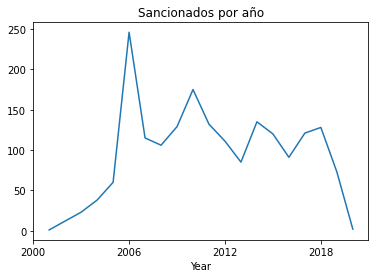

In [59]:
df_sancionados = pd.read_csv('../data/bases/RFC_sancionado.csv',
                             header=None, names=['Proveedor y Contratista ', 'Expediente'], sep='|')

df_sancionados = clean_base_sancionados(df_sancionados)

# El año de la sanción se obtiene del Expediente
get_year = lambda expediente: int(expediente.split('/')[1])
assert get_year('006410041/2013') == 2013

df_sancionados = df_sancionados.assign(Year=df_sancionados.Expediente.map(get_year))

print(df_sancionados.head())
df_sancionados.groupby('Year').agg('count').Expediente.plot(xticks=range(2000, 2020, 6),
                                                            title='Sancionados por año')

## 2.5 RFC fantasma

Esta base es la versión actualizada (al 19 de Febrero de 2020) de [Tabla de RFC fantasma](https://github.com/imco/irc#datos-procesados). En esta versión extraemos el listado de RFCs clasificados como **Definitivos** del sitio oficial [Integración de Sistema del SAT (API) para validación de facturas](http://omawww.sat.gob.mx/cifras_sat/Paginas/datos/vinculo.html?page=ListCompleta69B.html).

In [63]:
from utils.clean_data import clean_base_rfc

In [65]:
df_fantasma = pd.read_csv('../data/bases/Definitivos.csv',
                          dtype={'RFC': str, 'Nombre del Contribuyente': str},
                          encoding='iso-8859-1',
                          parse_dates=['Publicación página SAT definitivos'],
                          skiprows=2,
                          usecols=['RFC', 'Nombre del Contribuyente', 'Publicación página SAT definitivos'])

df_fantasma = df_fantasma.rename(columns={'Nombre del Contribuyente': 'Nombre del Contribuyente'.upper()})

# Filtra los RFC suprimidos
df_fantasma = df_fantasma.loc[df_fantasma.RFC != 'XXXXXXXXXXXX']

df_fantasma = clean_base_rfc(df_fantasma)
df_fantasma

,RFC,PROVEEDOR_CONTRATISTA,Publicación página SAT definitivos
0,AAA120730823,ASESORES Y ADMINISTRADORES AGRICOLAS,25/05/2018
1,AAA121206EV5,AMERICA ADMINISTRATIVA ARROLLO,25/10/2019
2,AAA1502061S0,ACUESY ASESORIA ACUICOLA ESPECIALIZADA DE YUCATAN,16/03/2018
3,AAAA620217U54,AMADOR AQUINO JOSE AVENAMAR,23/11/2018
4,AAAG7012036UA,ARAGON AYALA GRICELDA,25/05/2018
...,...,...,...
9402,ZTM130923IB2,ZADOK TECHNOLOGIES DE MEXICO,25/02/2019
9403,ZTP101230N53,ZARATE TOLEDO Y PACHECO GRUPO CONSULTOR,24/04/2017
9404,ZUCV601108NYA,ZUNIGA CASTILLO VICTOR,23/03/2018
9405,ZUL131022LD6,ZULPER,20/09/2018


# 3. Cálculo de features

En esta parte debes de cambiar las direcciones de salida de los features, nosotros usamos: '../data/conceptos/{concepto}/{tipo de contratacion}/features.csv'

In [13]:
%autoreload 2


import os

from features.general import (
    conteo_procedimientos,
    monto_total,
    num_proveedores_unicos,
    numero_contratos
)

from features.competencia import (
    c4_monto_total,
    c4_num_procedimientos,
    contratos_por_proveedor,
    disminucion_en_participacion,
    id_por_contratos,
    id_por_monto,
    ihh_por_contratos,
    ihh_por_monto,
    importe_promedio_por_contrato,
    pc_licitaciones_con_un_participante,
    pc_monto_adj_directa_inv3,
    pc_partipaciones_promedio,
    pc_procedimientos_adj_directa_inv3,
    procs_por_participantes_unicos,
    procs_promedio_por_participantes,
    tendencia_adjudicacion_directa,
    participantes_por_ganadores
)

from features.transparencia import (
    contratos_promedio_por_procedimimento,
    pc_adjudicaciones_incompletas,
    pc_inconsistencias_en_monto,
    pc_invitaciones_incompletas,
    pc_licitaciones_incompletas,
    pc_procs_con_provs_faltantes,
    pc_procs_sin_apertura,
    pc_procs_sin_archivos,
    pc_procs_sin_contrato,
    pc_procs_sin_fallo,
    pc_procs_sin_junta_aclaracion,
    porcentaje_procs_presenciales,
    promedio_datos_faltantes_por_contrato,
    promedio_procs_por_archivo,
    tendencia_no_publicacion_contratos
)

from features.anomalias import (
    monto_con_rfc_fantasma,
    monto_con_sancionados,
    pc_adj_directas_excedieron_monto,
    pc_contratos_con_convenio,
    pc_estratificacion_mal_reportada,
    pc_invitaciones_excedieron_monto,
    pc_licitaciones_internacionales_menor_20_dias,
    pc_licitaciones_internacionales_menor_40_dias,
    pc_licitaciones_nacionales_menor_15_dias,
    pc_procs_sin_convocatoria,
    promedio_convenios_por_proc
)

In [14]:
conceptos = ['general', 'competencia', 'transparencia', 'anomalias']

tipos_contratacion = (
    'ADQUISICIONES',
    'SERVICIOS',
    'OBRA PUBLICA',
    'ARRENDAMIENTOS',
    'SERVICIOS RELACIONADOS CON LA OP'
)

Hacemos un _groupby_ para ver la distribución de registros por Tipo de Contratación y Fecha.

In [17]:
df_procedimientos.groupby(['FECHA_ARCHIVO', 'TIPO_CONTRATACION']).count().iloc[:, 0]

FECHA_ARCHIVO  TIPO_CONTRATACION               
2018           ADQUISICIONES                        92000
               ARRENDAMIENTOS                        1109
               OBRA PUBLICA                          7109
               SERVICIOS                            71106
               SERVICIOS RELACIONADOS CON LA OP      2923
2019           ADQUISICIONES                       101397
               ARRENDAMIENTOS                        1062
               OBRA PUBLICA                          4215
               SERVICIOS                            66565
               SERVICIOS RELACIONADOS CON LA OP      2046
Name: DEPENDENCIA, dtype: int64

Creamos la estructura de directorios para guardar los features CSV a generar.

In [18]:
cwd = '../data/conceptos'
if not os.path.exists(cwd):
    os.mkdir(cwd)
    
for c in conceptos:
    pdir = os.path.join(cwd, c)
    if not os.path.exists(pdir):
        os.mkdir(pdir)
        
    for t in tipos_contratacion:
        subdir = os.path.join(pdir, t)
        if not os.path.exists(subdir):
            os.mkdir(subdir)

El siguiente ciclo pasa por cada año y tipo de contratación y calcula los indicadores seleccionados. Los resultados los escribe en disco en los archivos bajo la carpeta definida anteriormente.

In [66]:
def concatena_concepto(base, indicadores):
    concatenated = pd.concat(indicadores, axis=1, join='outer')
    concatenated.reset_index()
    return base.join(concatenated, how='left', on='CLAVEUC')


for tipo in tipos_contratacion:
    print('*' * 50, '\n' + tipo)
    
    general = pd.DataFrame()
    competencia = pd.DataFrame()
    transparencia = pd.DataFrame()
    anomalias = pd.DataFrame()
    
    # Acumula indicadores por año
    for i, year in enumerate(years):
        print(year)
        
        # sub-tablas por tipo y año
        df_procs_aux = df_procedimientos.loc[            
            (df_procedimientos.TIPO_CONTRATACION == tipo) &
            (df_procedimientos.FECHA_INICIO.dt.year == year)            
        ]
        
        df_scraper_aux = df_scraper.loc[
            (df_scraper.TIPO_CONTRATACION == tipo) &
            (df_scraper.FECHA_INICIO.dt.year == year)
        ]

        # df_parts_aux = df_participantes.loc[(df_participantes.TIPO_CONTRATACION == tipo) & (df_participantes.FECHA_INICIO.dt.year == year)]
        
        df_base = pd.DataFrame(df_procs_aux.CLAVEUC.unique(), columns=['CLAVEUC'])
        df_base['FECHA'] = year
        
        # - general ---------------------------------
        dfs_general = [
            conteo_procedimientos(df_procs_aux),
            monto_total(df_procs_aux),
            num_proveedores_unicos(df_procs_aux),
            numero_contratos(df_procs_aux)
        ]

        dfs_general = [df.set_index('CLAVEUC') for df in dfs_general if df is not None]
        
        print('General', [df.shape[0] for df in dfs_general])
        general = general.append(concatena_concepto(df_base, dfs_general)) 
        print(f'shape general: {general.shape}')
        del dfs_general
        print('-' * 50)

        # - competencia ---------------------
        dfs_competencia = [
            # pc_licitaciones_con_un_participante(df_parts_aux),
            # pc_partipaciones_promedio(df_parts_aux),
            # disminucion_en_participacion(df_parts_aux),
            # procs_por_participantes_unicos(df_parts_aux),
            pc_procedimientos_adj_directa_inv3(df_procs_aux),
            pc_monto_adj_directa_inv3(df_procs_aux),
            ihh_por_contratos(df_procs_aux),
            ihh_por_monto(df_procs_aux),
            id_por_contratos(df_procs_aux),
            id_por_monto(df_procs_aux),
            # procs_promedio_por_participantes(df_parts_aux),
            contratos_por_proveedor(df_procs_aux),
            c4_num_procedimientos(df_procs_aux),
            c4_monto_total(df_procs_aux),
            importe_promedio_por_contrato(df_procs_aux),
            # participantes_por_ganadores(df_parts_aux)
        ]
        
        # Para calcular tendencias se necesita un rango de años.
        if i > 0:
            df_procs_all = df_procedimientos.loc[(df_procedimientos.TIPO_CONTRATACION == tipo)]
            dfs_competencia.append(tendencia_adjudicacion_directa(df_procs_all, year=year))
            del df_procs_all

        dfs_competencia = [df.set_index('CLAVEUC') for df in dfs_competencia if df is not None]
        
        print('Competencia', [df.shape[0] for df in dfs_competencia])
        competencia = competencia.append(concatena_concepto(df_base, dfs_competencia))        
        print(f'shape competencia: {competencia.shape}')
        del dfs_competencia
        print('-' * 50)
        
        # - transparencia ----------------------------------
        dfs_transparencia = [
            promedio_datos_faltantes_por_contrato(df_procs_aux),
            pc_adjudicaciones_incompletas(df_scraper_aux),
            pc_invitaciones_incompletas(df_scraper_aux),
            pc_licitaciones_incompletas(df_scraper_aux),
            porcentaje_procs_presenciales(df_procs_aux),
            pc_procs_sin_junta_aclaracion(df_scraper_aux),
            pc_procs_sin_apertura(df_scraper_aux),
            pc_procs_sin_fallo(df_scraper_aux),
            pc_procs_sin_contrato(df_scraper_aux),
            pc_procs_sin_archivos(df_scraper_aux),
            # pc_inconsistencias_en_monto(df_procs_aux, df_parts_aux),
            # pc_procs_con_provs_faltantes(df_procs_aux, df_parts_aux)
        ]
        
        # Para calcular tendencias se necesita un rango de años.
        if i > 0:
            df_scraper_all = df_scraper.loc[(df_scraper.TIPO_CONTRATACION == tipo)]
            dfs_transparencia.append(tendencia_no_publicacion_contratos(df_scraper_all, year=year))
            del df_scraper_all

        dfs_transparencia = [df.set_index('CLAVEUC') for df in dfs_transparencia if df is not None]

        print('Transparencia', [df.shape[0] for df in dfs_transparencia])
        transparencia = transparencia.append(concatena_concepto(df_base, dfs_transparencia))
        print(f'shape transparencia: {transparencia.shape}')
        del dfs_transparencia
        print('-' * 50)
        
        # - anomalias -
        dfs_anomalias = [
            monto_con_rfc_fantasma(df_procs_aux, df_fantasma),
            monto_con_sancionados(df_procs_aux, df_sancionados),
            pc_contratos_con_convenio(df_procs_aux),
            promedio_convenios_por_proc(df_scraper_aux),
            pc_licitaciones_nacionales_menor_15_dias(df_procs_aux),
            pc_licitaciones_internacionales_menor_20_dias(df_procs_aux),
            pc_licitaciones_internacionales_menor_40_dias(df_procs_aux),
            pc_estratificacion_mal_reportada(df_procs_aux),
            pc_adj_directas_excedieron_monto(df_procs_aux, df_montos_maximos, tipo_contratacion=tipo, year=year),
            pc_invitaciones_excedieron_monto(df_procs_aux, df_montos_maximos, tipo_contratacion=tipo, year=year),
            pc_procs_sin_convocatoria(df_scraper_aux)
        ]
        
        dfs_anomalias = [df.set_index('CLAVEUC') for df in dfs_anomalias if df is not None]

        print('Anomalias', [df.shape[0] for df in dfs_anomalias])  
        anomalias = anomalias.append(concatena_concepto(df_base, dfs_anomalias))
        print(f'shape anomalias: {anomalias.shape}')
        del dfs_anomalias
        print('-' * 50)
        
    # Guarda los indicadores en disco: ../data/conceptos/<conceptos>/{tipo}/features.csv
    general.to_csv(f'../data/conceptos/general/{tipo}/features.csv', index=False, quoting=1, encoding='utf-8')
    del general
    competencia.to_csv(f'../data/conceptos/competencia/{tipo}/features.csv', index=False, quoting=1, encoding='utf-8')
    del competencia
    transparencia.to_csv(f'../data/conceptos/transparencia/{tipo}/features.csv', index=False, quoting=1, encoding='utf-8')
    del transparencia
    anomalias.to_csv(f'../data/conceptos/anomalias/{tipo}/features.csv', index=False, quoting=1, encoding='utf-8')
    del anomalias

************************************************** 
ADQUISICIONES
2018
General [849, 849, 849, 849]
shape general: (849, 6)
--------------------------------------------------
Competencia [849, 849, 849, 849, 849, 849, 849, 849, 849, 849]
shape competencia: (849, 12)
--------------------------------------------------
Transparencia [849, 846, 846, 846, 849, 846, 846, 846, 846, 846]
shape transparencia: (849, 12)
--------------------------------------------------
Anomalias [849, 849, 849, 846, 849, 849, 849, 849, 849, 849, 846]
shape anomalias: (849, 13)
--------------------------------------------------
2019
General [822, 822, 822, 822]
shape general: (1671, 6)
--------------------------------------------------
Competencia [822, 822, 822, 822, 822, 822, 822, 822, 822, 822, 1011]
shape competencia: (1671, 13)
--------------------------------------------------
Transparencia [822, 802, 802, 802, 822, 802, 802, 802, 802, 802, 997]
shape transparencia: (1671, 13)
-----------------------------

# 4. Post-procesamiento

Para poder realizar operaciones de agregación a nivel Dependencia por ejemplo, vamos a requerir una manera de asociar la UC a la dependencia. Para esto cargaremos el [Directorio Unidades Compradoras (UC)](https://sites.google.com/site/cnetuc/directorio) de Compranet.

In [34]:
uc_colmap = {
    'Siglas de la Institución': 'SIGLAS',
    'Institución': 'DEPENDENCIA',
    'Clave de la UC': 'CLAVEUC'
}

df_uc = pd.read_excel(db_path + '/UC_200629060540.xlsx',
                      encoding='iso-8859-1',
                      usecols=uc_colmap.keys())

df_uc.rename(inplace=True, columns=uc_colmap)
df_uc.to_csv(db_path + '/UC_200629060540.csv', sep=';', index=False)
df_uc

,SIGLAS,DEPENDENCIA,CLAVEUC
0,PR,Presidencia de la República,002000999
1,PR,Presidencia de la República,002000998
2,PR,Presidencia de la República,002000997
3,SEGOB,Secretaría de Gobernación,004000997
4,SEGOB,Secretaría de Gobernación,004000999
...,...,...,...
5557,ZAC,_Gobierno del Estado de Zacatecas,932080956
5558,ZAC,_Gobierno del Estado de Zacatecas,932079957
5559,ZAC,_Gobierno del Estado de Zacatecas,932042964
5560,ZAC,_Gobierno del Estado de Zacatecas,932078958
